In [ ]:
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# ASCAD data loading

In [ ]:
ascad_database = "/content/drive/MyDrive/ASCAD_databases/ASCAD.h5"
RANDOM_STATE = 42
VAL_SIZE = 0.1

In [ ]:
def check_file_exists(file_path):
	file_path = os.path.normpath(file_path)
	if os.path.exists(file_path) == False:
		print("Error: provided file path '%s' does not exist!" % file_path)
		sys.exit(-1)
	return

In [ ]:
def load_ascad(ascad_database_file, load_metadata=False):
	check_file_exists(ascad_database_file)
	# Open the ASCAD database HDF5 for reading
	try:
		in_file	 = h5py.File(ascad_database_file, "r")
	except:
		print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
		sys.exit(-1)
	# Load profiling traces
	X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
	# Load profiling labels
	Y_profiling = np.array(in_file['Profiling_traces/labels'])
	# Load attacking traces
	X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
	# Load attacking labels
	Y_attack = np.array(in_file['Attack_traces/labels'])
	if load_metadata == False:
		return (X_profiling, Y_profiling), (X_attack, Y_attack)
	else:
		return (X_profiling, Y_profiling), (X_attack, Y_attack), (in_file['Profiling_traces/metadata'], in_file['Attack_traces/metadata'])

In [ ]:
def create_tf_dataset(X, y, batch_size=64, shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((X, y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X))
  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
# Tuning
from sklearn.model_selection import train_test_split

(X_profiling, Y_profiling), (X_attack, Y_attack) = load_ascad(ascad_database)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_profiling, Y_profiling, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

Y_train_cat = to_categorical(Y_train, num_classes=256)
Y_val_cat = to_categorical(Y_val, num_classes=256)

X_train = X_train.reshape((-1, 700, 1))
X_val = X_val.reshape((-1, 700, 1))

In [ ]:
# Full training
from sklearn.model_selection import train_test_split

(X_profiling, Y_profiling), (X_attack, Y_attack) = load_ascad(ascad_database)

X_train_full = X_profiling
Y_train_cat = to_categorical(Y_profiling, num_classes=256)

In [ ]:
print(X_train.shape)
print(Y_train_cat.shape)

In [ ]:
# Full train
ds_train = create_tf_dataset(X_train_full, Y_train_cat)

In [ ]:
# Tuning
ds_train = create_tf_dataset(X_train, Y_train_cat)
ds_val = create_tf_dataset(X_val, Y_val_cat, shuffle=False)

In [ ]:
Y_train_cat.shape

(45000, 256)

# Transformer baseline

In [ ]:
!pip install

In [ ]:
from tensorflow.keras.layers import (Input, Dense, LayerNormalization, Dropout,
                                     MultiHeadAttention, GlobalAveragePooling1D,
                                     Embedding, Add, Conv1D, Reshape)
from tensorflow.keras.models import Model

def transformer_sca_baseline(
    input_length=700,
    num_classes=256,
    d_model=128,
    num_heads=4,
    ff_dim=256,
    dropout=0.1,
    num_blocks=4):

  inputs = Input(shape=(input_length,1))

  x = Conv1D(d_model, kernel_size=5, padding='same', activation='relu')(inputs)

  positions = tf.range(start=0, limit=input_length, delta=1)
  pos = Embedding(input_dim=700, output_dim=x.shape[-1])(positions)
  x = x + pos

  for _ in range(num_blocks):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    attn_output = Dropout(dropout)(attn_output)

    x = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn_output = Dense(ff_dim, activation='relu')(x)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)

    x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

  x = GlobalAveragePooling1D()(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs, name="transformer_sca_baseline")
  return model


In [ ]:
tfmr_sca_base = transformer_sca_baseline()
tfmr_sca_base.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
tfmr_sca_base.summary()

Model: "transformer_sca_baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 700, 128)  │        768 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 700, 128)  │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 700, 128)  │     66,048 │ add_14[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 700, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 700, 128)  │          0 │ add_14[0][0],     │
│                     │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 700, 128)  │        256 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 700, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 700, 128)  │     32,896 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 700, 128)  │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 700, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 700, 128)  │        256 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 700, 128)  │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 700, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 700, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 700, 128)  │        256 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 700, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 700, 128)  │     32,896 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 700, 128)  │          0 │ dense_17[0][0]  

 Total params: 563,712 (2.15 MB)

 Trainable params: 563,712 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tfmr_sca_base.fit(ds_train, batch_size=64, epochs=75, validation_data=ds_val, callbacks=[early_stop])

tfmr_sca_base.save("/content/drive/MyDrive/trfmr_baseline.keras")

Epoch 1/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 177ms/step - accuracy: 0.0042 - loss: 5.5519 - val_accuracy: 0.0044 - val_loss: 5.5551
Epoch 2/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 177ms/step - accuracy: 0.0044 - loss: 5.5677 - val_accuracy: 0.0048 - val_loss: 5.5548
Epoch 3/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 177ms/step - accuracy: 0.0039 - loss: 5.5551 - val_accuracy: 0.0044 - val_loss: 5.5496
Epoch 4/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.0040 - loss: 5.5491 - val_accuracy: 0.0044 - val_loss: 5.5473
Epoch 5/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.0037 - loss: 5.5462 - val_accuracy: 0.0036 - val_loss: 5.5477
Epoch 6/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.0043 - loss: 5.5458 - val_accuracy: 0.0044 - val_loss: 5.5458
Epoch 7/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.0043 - loss: 5.5447 - val_accuracy: 0.0044 - val_loss: 5.5461
Epoch 8/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.0051 -

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


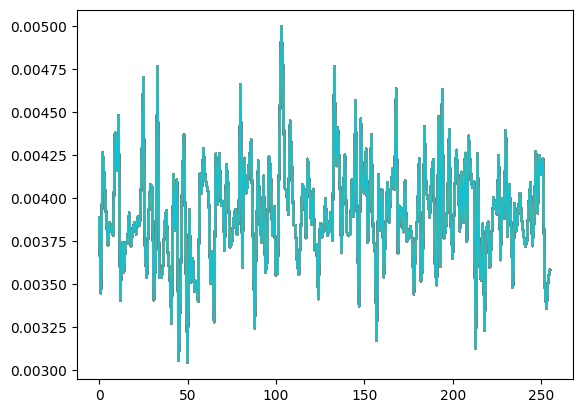

In [ ]:
import matplotlib.pyplot as plt

preds = tfmr_sca_base.predict(X_val[:100])
for pred in preds:
  plt.plot(pred)

In [ ]:
tfmr_sca_base_2 = transformer_sca_baseline()
tfmr_sca_base_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = tfmr_sca_base_2.fit(ds_train, batch_size=64, epochs=75, validation_data=ds_val)

tfmr_sca_base_2.save("/content/drive/MyDrive/trfmr_baseline_2.keras")

Epoch 1/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 168s 205ms/step - accuracy: 0.0040 - loss: 5.5859 - val_accuracy: 0.0032 - val_loss: 5.5562
Epoch 2/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 177ms/step - accuracy: 0.0041 - loss: 5.5580 - val_accuracy: 0.0044 - val_loss: 5.5556
Epoch 3/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 177ms/step - accuracy: 0.0050 - loss: 5.5495 - val_accuracy: 0.0046 - val_loss: 5.5463
Epoch 4/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 177ms/step - accuracy: 0.0049 - loss: 5.5478 - val_accuracy: 0.0044 - val_loss: 5.5471
Epoch 5/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 177ms/step - accuracy: 0.0053 - loss: 5.5465 - val_accuracy: 0.0044 - val_loss: 5.5493
Epoch 6/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 177ms/step - accuracy: 0.0048 - loss: 5.5465 - val_accuracy: 0.0046 - val_loss: 5.5483
Epoch 7/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 177ms/step - accuracy: 0.0042 - loss: 5.5466 - val_accuracy: 0.0046 - val_loss: 5.5467
Epoch 8/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 177ms/step - accuracy: 0.0043 -

In [ ]:
print(history_2)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, Dropout,
    MultiHeadAttention, GlobalAveragePooling1D,
    Conv1D, Embedding
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def transformer_sca_baseline(
    input_length=700,
    num_classes=256,
    d_model=64,
    num_heads=2,
    ff_dim=128,
    dropout=0.1,
    num_blocks=4
):
    # Input: traces of shape (700, 1)
    inputs = Input(shape=(input_length, 1))

    # Initial projection via 1D conv
    x = Conv1D(filters=d_model, kernel_size=5, padding='same', activation='relu')(inputs)

    # Fixed positional encoding using Embedding
    positions = tf.range(start=0, limit=input_length, delta=1)
    position_embedding = Embedding(input_dim=input_length, output_dim=d_model)
    pos_encoding = position_embedding(positions)  # shape: (700, d_model)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # shape: (1, 700, d_model)
    x = x + pos_encoding  # broadcasted across batch

    # Transformer encoder blocks
    for _ in range(num_blocks):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x)
        attn_output = Dropout(dropout)(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward network
        ffn_output = Dense(ff_dim, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout)(ffn_output)
        x = Add()([x, ffn_output])
        x = LayerNormalization(epsilon=1e-6)(x)

    # Final global pooling + classification
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inputs, outputs=outputs, name="transformer_sca_baseline")


In [ ]:
model = transformer_sca_baseline()

# Use label smoothing to regularize softmax outputs
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

# Add early stopping to prevent long flat training
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    ds_train,
    validation_data=ds_val,
    batch_size=200,
    epochs=75,
    callbacks=[early_stop]
)

model.save("/content/drive/MyDrive/trfmr_baseline_fixed.keras")


Epoch 1/75
310/704 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.0038 - loss: 5.5699

KeyboardInterrupt: 

# pytorch

In [ ]:
import os
import sys
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

RANDOM_STATE = 42
VAL_SIZE = 0.1

def check_file_exists(file_path):
    file_path = os.path.normpath(file_path)
    if not os.path.exists(file_path):
        print(f"Error: provided file path '{file_path}' does not exist!")
        sys.exit(-1)

def load_ascad(ascad_database_file):
    check_file_exists(ascad_database_file)
    with h5py.File(ascad_database_file, "r") as f:
        X_profiling = np.array(f['Profiling_traces/traces'], dtype=np.float32)
        Y_profiling = np.array(f['Profiling_traces/labels'], dtype=np.int64)
        X_attack = np.array(f['Attack_traces/traces'], dtype=np.float32)
        Y_attack = np.array(f['Attack_traces/labels'], dtype=np.int64)
    return (X_profiling, Y_profiling), (X_attack, Y_attack)


In [ ]:
class ASCADDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (N, 1, 700)
        self.y = torch.tensor(y, dtype=torch.long)  # integer labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
ascad_path = "/content/drive/MyDrive/ASCAD_databases/ASCAD.h5"
(X_profiling, Y_profiling), (X_attack, Y_attack) = load_ascad(ascad_path)

# Normalize if needed (standard in ASCAD)
X_profiling /= 255.0
X_attack /= 255.0

# Train/val split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_profiling, Y_profiling, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

# Dataset and loaders
train_ds = ASCADDataset(X_train, Y_train)
val_ds = ASCADDataset(X_val, Y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=700):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class TransformerSCA(nn.Module):
    def __init__(self, input_length=700, num_classes=256, d_model=32,
                 num_heads=2, ff_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Conv1d(1, d_model, kernel_size=5, padding=2)
        self.pos_enc = PositionalEncoding(d_model, max_len=input_length)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True  # Important for (B, T, D) input shape
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (B, 1, L)
        x = self.input_proj(x)  # (B, d_model, L)
        x = x.permute(0, 2, 1)  # (B, L, d_model)
        x = self.pos_enc(x)
        x = self.transformer(x)  # (B, L, d_model)
        x = x.permute(0, 2, 1)  # (B, d_model, L)
        x = self.pool(x).squeeze(-1)  # (B, d_model)
        return self.fc(x)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
model = TransformerSCA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)  # (B, num_classes)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_val).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


Using: cuda
Epoch 1/50 Train Loss: 5.5682 Acc: 0.0042 Val Loss: 5.5548 Acc: 0.0036
Epoch 2/50 Train Loss: 5.5536 Acc: 0.0037 Val Loss: 5.5502 Acc: 0.0046
Epoch 3/50 Train Loss: 5.5528 Acc: 0.0045 Val Loss: 5.5511 Acc: 0.0038
Epoch 4/50 Train Loss: 5.5515 Acc: 0.0040 Val Loss: 5.5506 Acc: 0.0046
Epoch 5/50 Train Loss: 5.5515 Acc: 0.0039 Val Loss: 5.5476 Acc: 0.0044
Epoch 6/50 Train Loss: 5.5507 Acc: 0.0041 Val Loss: 5.5514 Acc: 0.0042
Epoch 7/50 Train Loss: 5.5506 Acc: 0.0043 Val Loss: 5.5481 Acc: 0.0042
Epoch 8/50 Train Loss: 5.5500 Acc: 0.0040 Val Loss: 5.5498 Acc: 0.0046
Epoch 9/50 Train Loss: 5.5495 Acc: 0.0043 Val Loss: 5.5474 Acc: 0.0054
Epoch 10/50 Train Loss: 5.5497 Acc: 0.0039 Val Loss: 5.5472 Acc: 0.0048
Epoch 11/50 Train Loss: 5.5496 Acc: 0.0037 Val Loss: 5.5482 Acc: 0.0032
Epoch 12/50 Train Loss: 5.5493 Acc: 0.0044 Val Loss: 5.5481 Acc: 0.0042
Epoch 13/50 Train Loss: 5.5491 Acc: 0.0042 Val Loss: 5.5476 Acc: 0.0036
Epoch 14/50 Train Loss: 5.5485 Acc: 0.0039 Val Loss: 5.5494 A

In [ ]:
torch.save(model, "/content/drive/MyDrive/transformer_sca_full_model.pt")


In [ ]:
torch.save(model, "/content/drive/MyDrive/transformer_sca_full_model_2.pt")

## Overfit sanity check

In [ ]:
small_X = torch.tensor(X_train[:512], dtype=torch.float32).unsqueeze(1).to(device)
small_y = torch.tensor(Y_train[:512], dtype=torch.long).to(device)

In [ ]:
import numpy as np
np.unique(small_y.cpu()).shape

(220,)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

debug_dataset = TensorDataset(small_X, small_y)

debug_loader = DataLoader(debug_dataset, batch_size=64, shuffle=True)

In [ ]:
model = TransformerSCA(d_model=32, num_heads=2, ff_dim=64, num_layers=2, dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 100

for epoch in range(num_epochs):
  model.train()

  running_loss = 0
  correct = 0

  for xb, yb in debug_loader:
    xb, yb = xb.to(device), yb.to(device)

    optimizer.zero_grad()
    output = model(xb)
    loss = criterion(output, yb)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * xb.size(0)
    correct += (output.argmax(1) == yb).sum().item()

    acc = correct / len(debug_loader.dataset)
    print(f"Epoch {epoch}: Loss = {running_loss/len(debug_loader.dataset):.4f}, Acc = {acc:.4f}")

Epoch 0: Loss = 0.7017, Acc = 0.0000
Epoch 0: Loss = 1.4093, Acc = 0.0000
Epoch 0: Loss = 2.1168, Acc = 0.0000
Epoch 0: Loss = 2.8117, Acc = 0.0000
Epoch 0: Loss = 3.5215, Acc = 0.0000
Epoch 0: Loss = 4.2195, Acc = 0.0000
Epoch 0: Loss = 4.9217, Acc = 0.0000
Epoch 0: Loss = 5.6101, Acc = 0.0000
Epoch 1: Loss = 0.6853, Acc = 0.0020
Epoch 1: Loss = 1.3764, Acc = 0.0020
Epoch 1: Loss = 2.0715, Acc = 0.0020
Epoch 1: Loss = 2.7673, Acc = 0.0020
Epoch 1: Loss = 3.4607, Acc = 0.0020
Epoch 1: Loss = 4.1534, Acc = 0.0020
Epoch 1: Loss = 4.8491, Acc = 0.0020
Epoch 1: Loss = 5.5406, Acc = 0.0020
Epoch 2: Loss = 0.6942, Acc = 0.0000
Epoch 2: Loss = 1.3796, Acc = 0.0000
Epoch 2: Loss = 2.0664, Acc = 0.0000
Epoch 2: Loss = 2.7637, Acc = 0.0000
Epoch 2: Loss = 3.4536, Acc = 0.0000
Epoch 2: Loss = 4.1339, Acc = 0.0020
Epoch 2: Loss = 4.8198, Acc = 0.0039
Epoch 2: Loss = 5.5104, Acc = 0.0039
Epoch 3: Loss = 0.6795, Acc = 0.0000
Epoch 3: Loss = 1.3607, Acc = 0.0000
Epoch 3: Loss = 2.0461, Acc = 0.0000
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class TinyCNN(nn.Module):
    def __init__(self, input_len=700, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=11, padding=5),  # (B, 32, 700)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # (B, 64, 700)
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),                      # (B, 64, 1)
            nn.Flatten(),                                 # (B, 64)
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
model = TinyCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
  model.train()

  running_loss = 0
  correct = 0

  for xb, yb in debug_loader:
    xb, yb = xb.to(device), yb.to(device)

    optimizer.zero_grad()
    output = model(xb)
    loss = criterion(output, yb)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * xb.size(0)
    correct += (output.argmax(1) == yb).sum().item()

    acc = correct / len(debug_loader.dataset)
    print(f"Epoch {epoch}: Loss = {running_loss/len(debug_loader.dataset):.4f}, Acc = {acc:.4f}")

Epoch 0: Loss = 0.6944, Acc = 0.0000
Epoch 0: Loss = 1.3890, Acc = 0.0000
Epoch 0: Loss = 2.0840, Acc = 0.0039
Epoch 0: Loss = 2.7772, Acc = 0.0059
Epoch 0: Loss = 3.4708, Acc = 0.0059
Epoch 0: Loss = 4.1654, Acc = 0.0059
Epoch 0: Loss = 4.8606, Acc = 0.0059
Epoch 0: Loss = 5.5552, Acc = 0.0078
Epoch 1: Loss = 0.6927, Acc = 0.0000
Epoch 1: Loss = 1.3870, Acc = 0.0020
Epoch 1: Loss = 2.0782, Acc = 0.0039
Epoch 1: Loss = 2.7723, Acc = 0.0039
Epoch 1: Loss = 3.4644, Acc = 0.0039
Epoch 1: Loss = 4.1558, Acc = 0.0039
Epoch 1: Loss = 4.8462, Acc = 0.0078
Epoch 1: Loss = 5.5408, Acc = 0.0078
Epoch 2: Loss = 0.6919, Acc = 0.0020
Epoch 2: Loss = 1.3844, Acc = 0.0020
Epoch 2: Loss = 2.0732, Acc = 0.0020
Epoch 2: Loss = 2.7628, Acc = 0.0059
Epoch 2: Loss = 3.4541, Acc = 0.0078
Epoch 2: Loss = 4.1432, Acc = 0.0078
Epoch 2: Loss = 4.8321, Acc = 0.0078
Epoch 2: Loss = 5.5245, Acc = 0.0078
Epoch 3: Loss = 0.6888, Acc = 0.0000
Epoch 3: Loss = 1.3765, Acc = 0.0039
Epoch 3: Loss = 2.0656, Acc = 0.0039
E

In [ ]:
X_rand = torch.rand(200, 1, 700).to(device)
y_rand = torch.randint(0, 2, (200,))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

rand_dataset = TensorDataset(small_X, small_y)

rand_loader = DataLoader(rand_dataset, batch_size=64, shuffle=True)

In [ ]:
model = TinyCNN(num_classes=2) #.to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
  model.train()

  running_loss = 0
  correct = 0

  for xb, yb in rand_loader:
    # xb, yb = xb.to(device), yb.to(device)

    optimizer.zero_grad()
    output = model(xb)

    print("out shape:", output.shape)   # should be (64, 256)
    print("yb shape:", yb.shape)        # should be (64,)
    print("yb dtype:", yb.dtype)        # should be torch.int64
    print("preds:", output.argmax(1)[:5])
    print("true :", yb[:5])
    # break

    loss = criterion(output, yb)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * xb.size(0)
    correct += (output.argmax(1) == yb).sum().item()

    acc = correct / len(rand_loader.dataset)
    print(f"Epoch {epoch}: Loss = {running_loss/len(rand_loader.dataset):.4f}, Acc = {acc:.4f}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, Dropout,
    MultiHeadAttention, GlobalAveragePooling1D,
    Conv1D, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Step 1: Create synthetic data
X = np.random.randn(200, 700, 1).astype(np.float32)  # (200, 700, 1)
y = np.random.randint(0, 2, size=(200,))             # binary labels (0 or 1)

# Step 2: Build Transformer model
def transformer_mini(input_length=700, num_classes=2, d_model=32, num_heads=2, ff_dim=64, dropout=0.0):
    inputs = Input(shape=(input_length, 1))

    # Project input to d_model
    x = Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(inputs)

    # Positional encoding (fixed sinusoidal for simplicity)
    positions = tf.range(start=0, limit=input_length, delta=1)
    pos_enc = tf.keras.layers.Embedding(input_length, d_model)(positions)
    pos_enc = tf.expand_dims(pos_enc, 0)  # shape (1, L, D)
    x = x + pos_enc  # broadcasting

    # Transformer block
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn_output = Dense(ff_dim, activation='relu')(x)
    ffn_output = Dense(d_model)(ffn_output)
    x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Pooling + output
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes)(x)

    return Model(inputs, outputs)

# Step 3: Prepare training
model = transformer_mini()
model.compile(
    optimizer=Adam(1e-3),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Step 4: Train on tiny set to overfit
history = model.fit(
    X, y,
    batch_size=32,
    epochs=100,
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 841ms/step - accuracy: 0.4680 - loss: 0.7258
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step - accuracy: 0.4835 - loss: 0.7035
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 732ms/step - accuracy: 0.5028 - loss: 0.7129
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 657ms/step - accuracy: 0.5294 - loss: 0.6997
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 665ms/step - accuracy: 0.5284 - loss: 0.6957
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 572ms/step - accuracy: 0.4203 - loss: 0.7067
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 687ms/step - accuracy: 0.5032 - loss: 0.6990
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 643ms/step - accuracy: 0.4563 - loss: 0.7120
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - accuracy: 0.5353 - loss: 0.6902
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 695ms/step - accuracy: 0.5276 - loss: 0.6995
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 677ms/step - accuracy: 0.5358 - loss: 0.6932
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 768ms/step - accurac

KeyboardInterrupt: 

In [30]:
import numpy as np

# Define the number of samples and features
num_samples = 200
num_features = 700
num_classes = 2

# Generate random input data (X)
X = np.random.rand(num_samples, num_features)

# Generate random integer labels (y) for two classes
y = np.random.randint(0, num_classes, num_samples)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("First 5 samples of X:\n", X[:5])
print("First 5 labels of y:", y[:150])

np.sum(y[50:150])

Shape of X: (200, 700)
Shape of y: (200,)
First 5 samples of X:
 [[0.94729068 0.83018292 0.94396811 ... 0.71376634 0.14106948 0.05311945]
 [0.94706932 0.99742859 0.16382021 ... 0.05274973 0.9926633  0.80645876]
 [0.96522497 0.9934532  0.35787745 ... 0.58883575 0.66636795 0.94210572]
 [0.14347154 0.70811755 0.40753455 ... 0.07365959 0.7642488  0.94821592]
 [0.47506059 0.97611243 0.453808   ... 0.22125511 0.45341534 0.44366963]]
First 5 labels of y: [0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0
 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0
 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0
 0 1]


np.int64(49)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    attn_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    out = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed Forward Part
    ffn = keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),
        # The output dimension of the second Dense layer MUST match the input dimension
        layers.Dense(inputs.shape[-1])
    ])
    ffn_output = ffn(out) # Apply the sequential model to the output of the attention block
    ffn_output = layers.Dropout(dropout)(ffn_output)

    # Add the FFN output back to the skip connection (out)
    # Now out and ffn_output have the same shape (None, 700)
    return layers.LayerNormalization(epsilon=1e-6)(out + ffn_output)

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(2, activation="softmax")(x)  # Output layer for two classes
    return keras.Model(inputs, outputs)

# Model parameters
# Ensure X has the correct shape for the transformer (samples, sequence_length, features)
# The previous definition of X was (100, 700) which is missing the feature dimension (1)
num_samples = 100
num_features = 700
num_classes = 2

# Generate random input data (X) with shape (num_samples, num_features, 1)
X = np.random.rand(num_samples, num_features, 1).astype(np.float32)

# Generate random integer labels (y) for two classes
y = np.random.randint(0, num_classes, num_samples)


input_shape = X.shape[1:]  # (700, 1)
head_size = 64
num_heads = 2
ff_dim = 128
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.1
mlp_dropout = 0.1

# Build the Transformer model
model = build_transformer_model(
    input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout
)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

In [ ]:
# Train the model
epochs = 100  # You can increase this for more overfitting
batch_size = 32

history = model.fit(X, y, epochs=epochs, batch_size=batch_size)

# Evaluate the model on the training data
loss, accuracy = model.evaluate(X, y)
print(f"\nTraining Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy:.4f}")

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.4917 - loss: 0.6931
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5090 - loss: 0.6931
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5278 - loss: 0.6929
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5590 - loss: 0.6925
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.5007 - loss: 0.6932
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.5403 - loss: 0.6925
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.5132 - loss: 0.6929
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.5122 - loss: 0.6929
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.5090 - loss: 0.6930
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5153 - loss: 0.6928
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5205 - loss: 0.6927
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.4955 - loss: 0.6934
E

KeyboardInterrupt: 

In [2]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    attn_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    out = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed Forward Part
    ffn = keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),
        # The output dimension of the second Dense layer MUST match the input dimension
        layers.Dense(inputs.shape[-1])
    ])
    ffn_output = ffn(out) # Apply the sequential model to the output of the attention block
    ffn_output = layers.Dropout(dropout)(ffn_output)

    # Add the FFN output back to the skip connection (out)
    # Now out and ffn_output have the same shape (None, 700)
    return layers.LayerNormalization(epsilon=1e-6)(out + ffn_output)

In [3]:
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    # Reshape the input to (batch_size, sequence_length, 1)
    reshaped_inputs = layers.Reshape((input_shape[0], 1))(inputs)
    x = reshaped_inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(2, activation="softmax")(x)  # Output layer for two classes
    return keras.Model(inputs, outputs)

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Adjusted model parameters (increased capacity)
input_shape = X.shape[1:]  # (700, 1)
head_size = 32
num_heads = 1
ff_dim = 64
num_transformer_blocks = 1
mlp_units = [64]
dropout = 0.1
mlp_dropout = 0.1

# Re-build the Transformer model with increased capacity
model = build_transformer_model(
    input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout
)

# Re-compile the model with a potentially different learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model for more epochs
epochs = 200
batch_size = 32

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1) # Set verbose=1 to see epoch-wise progress

# Evaluate the model on the training data
loss, accuracy = model.evaluate(X, y, verbose=0)
print(f"\nTraining Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy:.4f}")

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4669 - loss: 0.6932
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4287 - loss: 0.6932 
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4724 - loss: 0.6932 
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4863 - loss: 0.6932 
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5191 - loss: 0.6931 
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4442 - loss: 0.6932 
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4685 - loss: 0.6931 
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4848 - loss: 0.6932 
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5351 - loss: 0.6931 
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5029 - loss: 0.6931 
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4324 - loss: 0.6932 
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4722 - loss

In [31]:
def baseline_mlp(input_shape=(700,1)):
  from tensorflow.keras.layers import Flatten, Input, Dense
  from tensorflow.keras.models import Model
  from tensorflow.keras.optimizers import Adam
  inputs = Input(shape=input_shape)
  x = Flatten()(inputs)
  x = Dense(512, activation='relu')(x)
  x = Dense(2)(x)
  return Model(inputs, x)

In [32]:
model = baseline_mlp()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(X,y, epochs=100, batch_size=32)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5380 - loss: 1.2610
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5393 - loss: 0.8978 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5252 - loss: 0.7670 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5535 - loss: 0.6946 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5958 - loss: 0.6419 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7757 - loss: 0.5703 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7163 - loss: 0.5531 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8228 - loss: 0.5018 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7885 - loss: 0.4734 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9172 - loss: 0.3924 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6472 - loss: 0.5000 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9139 - los

In [40]:
class FixedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, length, d_model):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

In [41]:
def transformer_mlp_baseline(input_length=700, d_model=32):
    inputs = tf.keras.layers.Input(shape=(input_length, 1))
    x = tf.keras.layers.Conv1D(d_model, kernel_size=5, padding='same', activation='relu')(inputs)

    # Positional encoding
    x = FixedPositionalEncoding(input_length, d_model)(x)

    # Basic Transformer Block
    attn = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=d_model//2)(x, x)
    x = tf.keras.layers.Add()([x, attn])
    x = tf.keras.layers.LayerNormalization()(x)

    ffn = tf.keras.layers.Dense(64, activation='relu')(x)
    ffn = tf.keras.layers.Dense(d_model)(ffn)
    x = tf.keras.layers.Add()([x, ffn])
    x = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(2)(x)

    return tf.keras.models.Model(inputs, outputs)

In [43]:
model = transformer_mlp_baseline()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(X, y, epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5456 - loss: 0.7362
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4968 - loss: 0.7231 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5038 - loss: 0.7092 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5168 - loss: 0.6967 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4126 - loss: 0.7173 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4887 - loss: 0.7053 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4878 - loss: 0.6950 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5246 - loss: 0.7002 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5288 - loss: 0.6905 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5004 - loss: 0.7018 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4679 - loss: 0.6956 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4915 - loss

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, LayerNormalization, Add, MultiHeadAttention

# ==== Fake linearly separable dataset ====
X = np.random.randn(200, 700, 1).astype(np.float32)
y = np.array([0]*100 + [1]*100)
np.random.shuffle(y)

# ==== Positional Encoding (sinusoidal) ====
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, length, d_model):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.encoding = tf.constant(angle_rads[np.newaxis, :, :], dtype=tf.float32)

    def call(self, x):
        return x + self.encoding[:, :tf.shape(x)[1], :]

# ==== Model ====
def transformer_overfit(input_len=700, d_model=32):
    inputs = Input(shape=(input_len, 1))
    x = Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(inputs)

    x = PositionalEncoding(input_len, d_model)(x)

    attn_out = MultiHeadAttention(num_heads=2, key_dim=d_model // 2)(x, x)
    x = Add()([x, attn_out])
    x = LayerNormalization()(x)

    ffn = Dense(64, activation='relu')(x)
    ffn = Dense(d_model)(ffn)
    x = Add()([x, ffn])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(2)(x)  # 2-class output

    return Model(inputs, outputs)

# ==== Compile and train ====
model = transformer_overfit()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.fit(X, y, batch_size=32, epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 629ms/step - accuracy: 0.5603 - loss: 0.6904
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5199 - loss: 0.7038 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4559 - loss: 0.7048 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5014 - loss: 0.6959 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4587 - loss: 0.7027 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5295 - loss: 0.6911 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4873 - loss: 0.6991 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4993 - loss: 0.6996 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5281 - loss: 0.6914 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4790 - loss: 0.6965 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5089 - loss: 0.6947 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4821 - l

In [50]:
from tensorflow.keras.layers import Lambda

def transformer_debug(input_len=700, d_model=32):
    inputs = Input(shape=(input_len, 1))
    x = Conv1D(d_model, kernel_size=3, padding='same', activation='relu')(inputs)

    # Positional encoding (skip for now)
    # x = PositionalEncoding(input_len, d_model)(x)

    # REMOVE attention: replace with identity to isolate bug
    attn_out = Lambda(lambda z: z)(x)  # identity layer
    x = Add()([x, attn_out])
    x = LayerNormalization()(x)

    ffn = Dense(128, activation='relu')(x)
    ffn = Dense(64, activation='relu')(x)
    ffn = Dense(d_model)(ffn)
    x = Add()([x, ffn])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(2)(x)
    return Model(inputs, outputs)

In [48]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [51]:
# ==== Compile and train ====
model = transformer_debug()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.fit(X, y, batch_size=32, epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.4675 - loss: 0.7457
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4895 - loss: 0.6986 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5147 - loss: 0.6934 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5168 - loss: 0.7058 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5246 - loss: 0.6938 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5072 - loss: 0.6964 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5072 - loss: 0.6989 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5614 - loss: 0.6945 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4869 - loss: 0.7003 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5172 - loss: 0.6943 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4435 - loss: 0.6957 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5410 - lo

In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.1.0 torchvision torchaudio

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of tor

In [1]:
import torch.nn as nn

class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.l = nn.Linear(10, 2)

    def forward(self, x):
        return self.l(x)

m = M()
print(list(m.parameters()))  # should show 2 tensors

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:20: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
  device: torch.device = torch.device(torch._C._get_default_device()),  # torch.device('cpu'),


[Parameter containing:
tensor([[ 0.2451, -0.0769, -0.0372, -0.2523, -0.2028,  0.2316,  0.0084,  0.1611,
         -0.3128, -0.0851],
        [-0.1445,  0.1622,  0.2241,  0.0041,  0.2379,  0.2644,  0.2776, -0.2513,
         -0.0179,  0.2518]], requires_grad=True), Parameter containing:
tensor([-0.1439,  0.0338], requires_grad=True)]


In [6]:
!pip install numpy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# === Create linearly separable data ===
num_samples = 10000
X = np.random.randn(num_samples, 700).astype(np.float32)
y = np.array([0]*(num_samples//2) + [1]*(num_samples//2))
np.random.shuffle(y)
print(X.dtype)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)  # shape: (200, 1, 700)
y = torch.tensor(y, dtype=torch.long).to(device)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# === Positional Encoding ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=700):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# === Transformer-like Model ===
class OverfitTransformer(nn.Module):
    def __init__(self, input_len=700, d_model=32, num_heads=2):
        super().__init__()
        self.proj = nn.Conv1d(1, d_model, kernel_size=5, padding=2)
        self.pos_enc = PositionalEncoding(d_model, max_len=input_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):  # x: (B, 1, 700)
        x = self.proj(x)             # (B, d_model, 700)
        x = x.permute(0, 2, 1)       # (B, 700, d_model)
        x = self.pos_enc(x)          # (B, 700, d_model)
        x = self.transformer(x)      # (B, 700, d_model)
        x = x.permute(0, 2, 1)       # (B, d_model, 700)
        x = self.pool(x).squeeze(-1) # (B, d_model)
        return self.fc(x)            # (B, 2)

model = OverfitTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# === Training loop ===
for epoch in range(100):
    model.train()
    total_loss, correct = 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (out.argmax(1) == yb).sum().item()

    acc = correct / len(loader.dataset)
    print(f"Epoch {epoch+1}: Loss={total_loss/len(loader.dataset):.4f}, Acc={acc:.4f}")
    if acc >= 0.99:
        print("✅ Overfit success.")
        break

Device: cuda
float32
Epoch 1: Loss=0.6975, Acc=0.4997
Epoch 2: Loss=0.6941, Acc=0.5028
Epoch 3: Loss=0.6943, Acc=0.4976
Epoch 4: Loss=0.6941, Acc=0.5004
Epoch 5: Loss=0.6940, Acc=0.4955
Epoch 6: Loss=0.6936, Acc=0.5033
Epoch 7: Loss=0.6936, Acc=0.5024
Epoch 8: Loss=0.6936, Acc=0.5050
Epoch 9: Loss=0.6936, Acc=0.4960
Epoch 10: Loss=0.6935, Acc=0.5004
Epoch 11: Loss=0.6932, Acc=0.5077
Epoch 12: Loss=0.6935, Acc=0.4972
Epoch 13: Loss=0.6934, Acc=0.4970
Epoch 14: Loss=0.6933, Acc=0.5014
Epoch 15: Loss=0.6934, Acc=0.4973
Epoch 16: Loss=0.6933, Acc=0.4978
Epoch 17: Loss=0.6933, Acc=0.4980
Epoch 18: Loss=0.6933, Acc=0.4930
Epoch 19: Loss=0.6934, Acc=0.4981
Epoch 20: Loss=0.6933, Acc=0.4993


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# === Fake linearly separable data ===
X = torch.randn(200, 1, 700)
y = torch.cat([torch.zeros(100), torch.ones(100)]).long()

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Positional Encoding ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=700):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# === CNN + Transformer Classifier ===
class CNNTransformer(nn.Module):
    def __init__(self, input_len=700, d_model=32, num_heads=2):
        super().__init__()

        # Local CNN feature extractor
        self.fe = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=11, padding=5),
            nn.ReLU(),
            nn.Conv1d(16, d_model, kernel_size=5, padding=2),
            nn.ReLU()
        )

        self.pos_enc = PositionalEncoding(d_model, max_len=input_len)

        # One-layer Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        # Final classifier
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):  # (B, 1, 700)
        x = self.fe(x)                 # (B, d_model, 700)
        x = x.permute(0, 2, 1)         # (B, 700, d_model)
        x = self.pos_enc(x)            # (B, 700, d_model)
        x = self.transformer(x)        # (B, 700, d_model)
        x = x.permute(0, 2, 1)         # (B, d_model, 700)
        x = self.pool(x).squeeze(-1)   # (B, d_model)
        return self.fc(x)              # (B, 2)

In [6]:
model = CNNTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        pred = out.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}")
    if acc >= 0.99:
        print("✅ Overfit success!")
        break

Epoch 1: Accuracy = 0.4600
Epoch 2: Accuracy = 0.5200
Epoch 3: Accuracy = 0.5000
Epoch 4: Accuracy = 0.4300
Epoch 5: Accuracy = 0.5000
Epoch 6: Accuracy = 0.4800
Epoch 7: Accuracy = 0.5000
Epoch 8: Accuracy = 0.4600
Epoch 9: Accuracy = 0.5000
Epoch 10: Accuracy = 0.4700
Epoch 11: Accuracy = 0.4600
Epoch 12: Accuracy = 0.4400
Epoch 13: Accuracy = 0.4800
Epoch 14: Accuracy = 0.4400
Epoch 15: Accuracy = 0.4950
Epoch 16: Accuracy = 0.5000
Epoch 17: Accuracy = 0.5000
Epoch 18: Accuracy = 0.5000
Epoch 19: Accuracy = 0.4800
Epoch 20: Accuracy = 0.4850
Epoch 21: Accuracy = 0.5000
Epoch 22: Accuracy = 0.5300
Epoch 23: Accuracy = 0.5000
Epoch 24: Accuracy = 0.5000
Epoch 25: Accuracy = 0.5000
Epoch 26: Accuracy = 0.5300
Epoch 27: Accuracy = 0.5000
Epoch 28: Accuracy = 0.5000
Epoch 29: Accuracy = 0.5050
Epoch 30: Accuracy = 0.5000
Epoch 31: Accuracy = 0.5000
Epoch 32: Accuracy = 0.5100
Epoch 33: Accuracy = 0.5000
Epoch 34: Accuracy = 0.5000
Epoch 35: Accuracy = 0.5000
Epoch 36: Accuracy = 0.5000
E